## Author: Fang Jung(Kristy) Lin 
## Purpose: Run a multiple regression model to predict active days

# Import necessary packages

In [1]:
import numpy as np
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import random
import os

from matplotlib import pyplot as plt
import pylab as pl
from matplotlib.ticker import PercentFormatter
from pylab import rcParams
import seaborn as sns

import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
import datetime as dt
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

# Purpose for the analysis

- Determine the causes of active day
- Use multiple regression model to predict players' active day


# Part1. Data Acquisition and Exploration

## Load the data from xlsx file

In [2]:
my_df = pd.read_excel('/Users/kristylin/Desktop/NEU Courses/Intro Analytics/w3/civ6_players _1_.xlsx')
my_df.head(3)

,PLAYERID,INSTALLDATE,ACTIVEDAYS,LASTACTIVEDAY,LEADERMOSTSELECTED,CIVILIZATIONMOSTSELECTED,POLAND,NUBIA,KHMER_AND_INDONESIA,GATHERING_STORM,PERSIA_AND_MACEDON,VIKINGS,RISE_AND_FALL,AUSTRALIA
0,3316379,2018-01-05,1,2018-01-05,LEADER_GILGAMESH,CIVILIZATION_SUMERIA,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,3316386,2018-01-05,3,2018-01-09,LEADER_TRAJAN,CIVILIZATION_ROME,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3316394,2018-01-05,115,2018-07-08,LEADER_T_ROOSEVELT,CIVILIZATION_AMERICA,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


## Interpret the data set

In [3]:
list(my_df)

['PLAYERID',
 'INSTALLDATE',
 'ACTIVEDAYS',
 'LASTACTIVEDAY',
 'LEADERMOSTSELECTED',
 'CIVILIZATIONMOSTSELECTED',
 'POLAND',
 'NUBIA',
 'KHMER_AND_INDONESIA',
 'GATHERING_STORM',
 'PERSIA_AND_MACEDON',
 'VIKINGS',
 'RISE_AND_FALL',
 'AUSTRALIA']

### Data set interpretion

- PLAYERID: Unique identifier of each player
- INSTALLDATE: Player's CIV6 install date
- ACTIVEDAYS: The number of unique days player played the game
- LASTACTIVEDAY: Last active day of the player
- LEADERMOSTSELECTED: Most selected leaders in the game
- CIVILIZATIONMOSTSELECTED: Most selected civilization in the game
- POLAND: Player's install date of this DLC
- NUBIA: Player's install date of this DLC
- KHMER_AND_INDONESIA: Player's install date of this DLC
- GATHERING_STORM: Player's install date of this Expansion Pack
- PERSIA_AND_MACEDON: Player's install date of this DLC
- VIKINGS: Player's install date of this DLC
- RISE_AND_FALL: Player's install date of this Expansion Pack
- AUSTRALIA: Player's install date of this DLC

## Data preprocessing

Check both the datatypes and if there are missing values

In [4]:
print('Datatype:\n', my_df.dtypes)
print('Missing values:\n', my_df.isnull().any())

Datatype:
 PLAYERID                             int64
INSTALLDATE                 datetime64[ns]
ACTIVEDAYS                           int64
LASTACTIVEDAY               datetime64[ns]
LEADERMOSTSELECTED                  object
CIVILIZATIONMOSTSELECTED            object
POLAND                      datetime64[ns]
NUBIA                       datetime64[ns]
KHMER_AND_INDONESIA         datetime64[ns]
GATHERING_STORM             datetime64[ns]
PERSIA_AND_MACEDON          datetime64[ns]
VIKINGS                     datetime64[ns]
RISE_AND_FALL               datetime64[ns]
AUSTRALIA                   datetime64[ns]
dtype: object
Missing values:
 PLAYERID                    False
INSTALLDATE                 False
ACTIVEDAYS                  False
LASTACTIVEDAY               False
LEADERMOSTSELECTED          False
CIVILIZATIONMOSTSELECTED    False
POLAND                       True
NUBIA                        True
KHMER_AND_INDONESIA          True
GATHERING_STORM              True
PERSIA_AND_MACED

- There are null values in Poland, Nubia, Khmer_and_Indonesia, Poland, Nubia, Khmer_and_Indonesia, Gathering_Storm, Persia_and_Macedon, Vikings, Rise_and_Fall, Australia.

- The null values means that not all the players bought the expansion packs and DLCs

### Remove unnecessary column
'PLAYERID' column is unnecessary for the analysis, so I drop itt from the dataframe

In [5]:
my_df = my_df.drop(columns = ['PLAYERID'])
my_df.head(3)

,INSTALLDATE,ACTIVEDAYS,LASTACTIVEDAY,LEADERMOSTSELECTED,CIVILIZATIONMOSTSELECTED,POLAND,NUBIA,KHMER_AND_INDONESIA,GATHERING_STORM,PERSIA_AND_MACEDON,VIKINGS,RISE_AND_FALL,AUSTRALIA
0,2018-01-05,1,2018-01-05,LEADER_GILGAMESH,CIVILIZATION_SUMERIA,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2018-01-05,3,2018-01-09,LEADER_TRAJAN,CIVILIZATION_ROME,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,2018-01-05,115,2018-07-08,LEADER_T_ROOSEVELT,CIVILIZATION_AMERICA,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


### Replace NaT Values with Zero & change values to 1 of expansion packs and DLCs

In [6]:
# Define a function to check the null data
def checknull(val):
    if val is pd.NaT:
        return 0
    else: 
        return 1

# Set up columns
tuples = [('POLAND', 'BUY_POLAND'), ('NUBIA', 'BUY_NUBIA'), ('KHMER_AND_INDONESIA', 'BUY_KHMER_AND_INDONESIA'),
         ('GATHERING_STORM','BUY_GATHERING_STORM'), ('PERSIA_AND_MACEDON', 'BUY_PERSIA_AND_MACEDON'),
         ('VIKINGS', 'BUY_VIKINGS'), ('RISE_AND_FALL', 'BUY_RISE_AND_FALL'), ('AUSTRALIA', 'BUY_AUSTRALIA')]

for old_col, new_col in tuples:
    my_df[new_col] = my_df.apply(lambda x: checknull(x[old_col]), axis = 1)
    
# Show the dataframe
my_df.head()

,INSTALLDATE,ACTIVEDAYS,LASTACTIVEDAY,LEADERMOSTSELECTED,CIVILIZATIONMOSTSELECTED,POLAND,NUBIA,KHMER_AND_INDONESIA,GATHERING_STORM,PERSIA_AND_MACEDON,...,RISE_AND_FALL,AUSTRALIA,BUY_POLAND,BUY_NUBIA,BUY_KHMER_AND_INDONESIA,BUY_GATHERING_STORM,BUY_PERSIA_AND_MACEDON,BUY_VIKINGS,BUY_RISE_AND_FALL,BUY_AUSTRALIA
0,2018-01-05,1,2018-01-05,LEADER_GILGAMESH,CIVILIZATION_SUMERIA,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,0,0,0,0,0,0,0,0
1,2018-01-05,3,2018-01-09,LEADER_TRAJAN,CIVILIZATION_ROME,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,0,0,0,0,0,0,0,0
2,2018-01-05,115,2018-07-08,LEADER_T_ROOSEVELT,CIVILIZATION_AMERICA,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,0,0,0,0,0,0,0,0
3,2018-03-04,112,2019-10-05,LEADER_HOJO,CIVILIZATION_JAPAN,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,0,0,0,0,0,0,0,0
4,2018-03-12,1,2018-03-12,LEADER_PALA,CIVILIZATION_PALA,NaT,NaT,2018-03-12,NaT,NaT,...,NaT,NaT,0,0,1,0,0,0,0,0


### Create new columns to count the number of DLCs or expansion packs that players owned

#### Create a total column to sum up DLCs + expansions

In [7]:
my_df['total'] = my_df['BUY_POLAND'] + my_df['BUY_NUBIA'] + my_df['BUY_KHMER_AND_INDONESIA'] 
+ my_df['BUY_GATHERING_STORM'] + my_df['BUY_PERSIA_AND_MACEDON'] 
+ my_df['BUY_VIKINGS'] + my_df['BUY_RISE_AND_FALL'] + my_df['BUY_AUSTRALIA']
my_df.head(1)

,INSTALLDATE,ACTIVEDAYS,LASTACTIVEDAY,LEADERMOSTSELECTED,CIVILIZATIONMOSTSELECTED,POLAND,NUBIA,KHMER_AND_INDONESIA,GATHERING_STORM,PERSIA_AND_MACEDON,...,AUSTRALIA,BUY_POLAND,BUY_NUBIA,BUY_KHMER_AND_INDONESIA,BUY_GATHERING_STORM,BUY_PERSIA_AND_MACEDON,BUY_VIKINGS,BUY_RISE_AND_FALL,BUY_AUSTRALIA,total
0,2018-01-05,1,2018-01-05,LEADER_GILGAMESH,CIVILIZATION_SUMERIA,NaT,NaT,NaT,NaT,NaT,...,NaT,0,0,0,0,0,0,0,0,0


#### Create a sum DLCs to count the number that each player owned

In [8]:
my_df['SUM_DLCS'] = my_df['BUY_GATHERING_STORM'] + my_df['BUY_RISE_AND_FALL']
my_df.head(1)

,INSTALLDATE,ACTIVEDAYS,LASTACTIVEDAY,LEADERMOSTSELECTED,CIVILIZATIONMOSTSELECTED,POLAND,NUBIA,KHMER_AND_INDONESIA,GATHERING_STORM,PERSIA_AND_MACEDON,...,BUY_POLAND,BUY_NUBIA,BUY_KHMER_AND_INDONESIA,BUY_GATHERING_STORM,BUY_PERSIA_AND_MACEDON,BUY_VIKINGS,BUY_RISE_AND_FALL,BUY_AUSTRALIA,total,SUM_DLCS
0,2018-01-05,1,2018-01-05,LEADER_GILGAMESH,CIVILIZATION_SUMERIA,NaT,NaT,NaT,NaT,NaT,...,0,0,0,0,0,0,0,0,0,0


#### Create a sum expansions to count the number that each player owned

In [9]:
my_df['SUM_expansions'] = my_df['BUY_POLAND'] + my_df['BUY_NUBIA'] + my_df['BUY_KHMER_AND_INDONESIA'] 
+ my_df['BUY_PERSIA_AND_MACEDON'] + my_df['BUY_VIKINGS'] + my_df['BUY_AUSTRALIA']
my_df.head(1)

,INSTALLDATE,ACTIVEDAYS,LASTACTIVEDAY,LEADERMOSTSELECTED,CIVILIZATIONMOSTSELECTED,POLAND,NUBIA,KHMER_AND_INDONESIA,GATHERING_STORM,PERSIA_AND_MACEDON,...,BUY_NUBIA,BUY_KHMER_AND_INDONESIA,BUY_GATHERING_STORM,BUY_PERSIA_AND_MACEDON,BUY_VIKINGS,BUY_RISE_AND_FALL,BUY_AUSTRALIA,total,SUM_DLCS,SUM_expansions
0,2018-01-05,1,2018-01-05,LEADER_GILGAMESH,CIVILIZATION_SUMERIA,NaT,NaT,NaT,NaT,NaT,...,0,0,0,0,0,0,0,0,0,0


### Convert values in leader and civilization from rows to columns and set up 0/1 for the values

#### Create new columns and set all the values to 0

In [10]:
for col in my_df.LEADERMOSTSELECTED.unique():
    my_df[col] = 0

for col in my_df.CIVILIZATIONMOSTSELECTED.unique():
    my_df[col] = 0   

# Print out dataframe
my_df.head(3)

,INSTALLDATE,ACTIVEDAYS,LASTACTIVEDAY,LEADERMOSTSELECTED,CIVILIZATIONMOSTSELECTED,POLAND,NUBIA,KHMER_AND_INDONESIA,GATHERING_STORM,PERSIA_AND_MACEDON,...,CIVILIZATION_yuduki,CIVILIZATION_FB_ANGLO_SAXONS,CIVILIZATION_CORONA,CIVILIZATION_RL_SHOSHONE,CIVILIZATION_SOCRA_GORYEO,CIVILIZATION_ETHIOPIA,CIVILIZATION_CG_IONIA,CIVILIZATION_SHIKI,CIVILIZATION_ALTMER,CIVILIZATION_CW
0,2018-01-05,1,2018-01-05,LEADER_GILGAMESH,CIVILIZATION_SUMERIA,NaT,NaT,NaT,NaT,NaT,...,0,0,0,0,0,0,0,0,0,0
1,2018-01-05,3,2018-01-09,LEADER_TRAJAN,CIVILIZATION_ROME,NaT,NaT,NaT,NaT,NaT,...,0,0,0,0,0,0,0,0,0,0
2,2018-01-05,115,2018-07-08,LEADER_T_ROOSEVELT,CIVILIZATION_AMERICA,NaT,NaT,NaT,NaT,NaT,...,0,0,0,0,0,0,0,0,0,0


#### Find the corresponding columns and set the value to 1

In [11]:
for i, row in my_df.iterrows():
    my_df.at[i, row['LEADERMOSTSELECTED']] = 1
    my_df.at[i, row['CIVILIZATIONMOSTSELECTED']] = 1
    
# Print out dataframe
my_df.head(3)

,INSTALLDATE,ACTIVEDAYS,LASTACTIVEDAY,LEADERMOSTSELECTED,CIVILIZATIONMOSTSELECTED,POLAND,NUBIA,KHMER_AND_INDONESIA,GATHERING_STORM,PERSIA_AND_MACEDON,...,CIVILIZATION_yuduki,CIVILIZATION_FB_ANGLO_SAXONS,CIVILIZATION_CORONA,CIVILIZATION_RL_SHOSHONE,CIVILIZATION_SOCRA_GORYEO,CIVILIZATION_ETHIOPIA,CIVILIZATION_CG_IONIA,CIVILIZATION_SHIKI,CIVILIZATION_ALTMER,CIVILIZATION_CW
0,2018-01-05,1,2018-01-05,LEADER_GILGAMESH,CIVILIZATION_SUMERIA,NaT,NaT,NaT,NaT,NaT,...,0,0,0,0,0,0,0,0,0,0
1,2018-01-05,3,2018-01-09,LEADER_TRAJAN,CIVILIZATION_ROME,NaT,NaT,NaT,NaT,NaT,...,0,0,0,0,0,0,0,0,0,0
2,2018-01-05,115,2018-07-08,LEADER_T_ROOSEVELT,CIVILIZATION_AMERICA,NaT,NaT,NaT,NaT,NaT,...,0,0,0,0,0,0,0,0,0,0


#### Test the result

In [12]:
print(my_df.iloc[0]['LEADER_GILGAMESH']) # should be 1
print(my_df.iloc[0]['LEADER_TRAJAN']) # should be 0
print(my_df.iloc[0]['LEADER_T_ROOSEVELT']) # should be 0

print(my_df.iloc[1]['CIVILIZATION_SUMERIA']) # should be 0
print(my_df.iloc[1]['CIVILIZATION_ROME']) # should be 1
print(my_df.iloc[1]['CIVILIZATION_AMERICA']) # should be 0

1
0
0
0
1
0


### Convert object to numerical value

In [13]:
le = LabelEncoder()

my_df['LEADERMOSTSELECTED']= le.fit_transform(my_df['LEADERMOSTSELECTED'])
my_df['CIVILIZATIONMOSTSELECTED']= le.fit_transform(my_df['CIVILIZATIONMOSTSELECTED'])

### Convert date data to numerical value

In [14]:
my_df['INSTALLDATE'] = my_df['INSTALLDATE'].map(dt.datetime.toordinal)
my_df['LASTACTIVEDAY'] = my_df['LASTACTIVEDAY'].map(dt.datetime.toordinal)
my_df.head(1)

,INSTALLDATE,ACTIVEDAYS,LASTACTIVEDAY,LEADERMOSTSELECTED,CIVILIZATIONMOSTSELECTED,POLAND,NUBIA,KHMER_AND_INDONESIA,GATHERING_STORM,PERSIA_AND_MACEDON,...,CIVILIZATION_yuduki,CIVILIZATION_FB_ANGLO_SAXONS,CIVILIZATION_CORONA,CIVILIZATION_RL_SHOSHONE,CIVILIZATION_SOCRA_GORYEO,CIVILIZATION_ETHIOPIA,CIVILIZATION_CG_IONIA,CIVILIZATION_SHIKI,CIVILIZATION_ALTMER,CIVILIZATION_CW
0,736699,1,736699,279,413,NaT,NaT,NaT,NaT,NaT,...,0,0,0,0,0,0,0,0,0,0


### Create a datediff column to find the difference between last active day and install day

In [15]:
my_df['datediff'] = my_df['LASTACTIVEDAY'] - my_df['INSTALLDATE']
my_df.head(1)

,INSTALLDATE,ACTIVEDAYS,LASTACTIVEDAY,LEADERMOSTSELECTED,CIVILIZATIONMOSTSELECTED,POLAND,NUBIA,KHMER_AND_INDONESIA,GATHERING_STORM,PERSIA_AND_MACEDON,...,CIVILIZATION_FB_ANGLO_SAXONS,CIVILIZATION_CORONA,CIVILIZATION_RL_SHOSHONE,CIVILIZATION_SOCRA_GORYEO,CIVILIZATION_ETHIOPIA,CIVILIZATION_CG_IONIA,CIVILIZATION_SHIKI,CIVILIZATION_ALTMER,CIVILIZATION_CW,datediff
0,736699,1,736699,279,413,NaT,NaT,NaT,NaT,NaT,...,0,0,0,0,0,0,0,0,0,0


## Explore active days variable

In [16]:
my_df['ACTIVEDAYS'].describe()

count    500000.000000
mean         23.590800
std          49.390431
min           1.000000
25%           3.000000
50%           8.000000
75%          22.000000
max        1081.000000
Name: ACTIVEDAYS, dtype: float64

###  Initial Findings

From the table above, we can find some information
- The mean active days among all players are 23.59 days. 
- The min active day is 1 and the max active days is 1081, the gap between the min and max active day is significant. 
- The standard deviation is 49.3, which is quite high. There must be some factors that can influence the payers' active day.

## Visualize partial variables' correlation

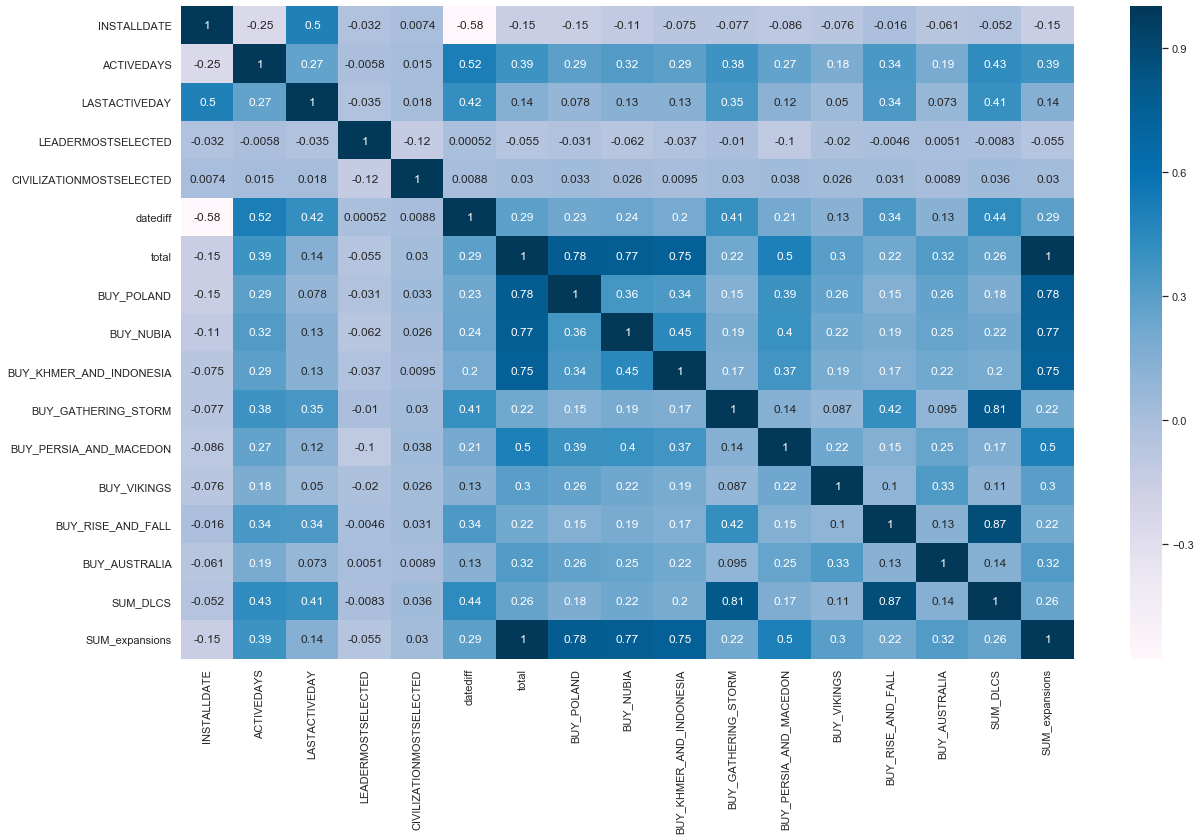

In [17]:
# Set up the plot size
sns.set(font_scale=1)
plt.figure(figsize=(20,12))

# Plot the heat map
corr_df = my_df[['INSTALLDATE','ACTIVEDAYS','LASTACTIVEDAY','LEADERMOSTSELECTED','CIVILIZATIONMOSTSELECTED',
 'POLAND','NUBIA','KHMER_AND_INDONESIA','GATHERING_STORM','PERSIA_AND_MACEDON','VIKINGS','RISE_AND_FALL',
 'AUSTRALIA','datediff', 'total', 'BUY_POLAND', 'BUY_NUBIA', 'BUY_KHMER_AND_INDONESIA', 'BUY_GATHERING_STORM',
 'BUY_PERSIA_AND_MACEDON', 'BUY_VIKINGS', 'BUY_RISE_AND_FALL', 'BUY_AUSTRALIA', 'SUM_DLCS', 'SUM_expansions']]
ax = sns.heatmap(corr_df.corr(), annot=True, cmap = 'PuBu')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.yticks(rotation=0)
plt.show()

###  Findings from the heat map

- The difference between last active day and install day has positive correlation with active days.
- The amount of DLCs that the player owned has positive correlation with active days.
- The amount of expansions that the player owned has positive correlation with active days.
- The total amount of expansions and DLCs that players have has positive correlation with active days.

We can conclude that if the players have bought DLCs or expansions, he/she may have more active days. Also, the more days difference between the players' last active day and install day, the more chance that the players have more active days.

Since there are many variables in the dataframe, I will use linear regression approach to train the model, and plot the highest coefficient variables with active days.

# Part2. Set up Dependence Variables and Independence Variables

### Convert datetime values to numerical values

In [18]:
my_df['POLAND']= le.fit_transform(my_df['POLAND'])
my_df['NUBIA']= le.fit_transform(my_df['NUBIA'])
my_df['KHMER_AND_INDONESIA']= le.fit_transform(my_df['KHMER_AND_INDONESIA'])
my_df['GATHERING_STORM']= le.fit_transform(my_df['GATHERING_STORM'])
my_df['PERSIA_AND_MACEDON']= le.fit_transform(my_df['PERSIA_AND_MACEDON'])
my_df['VIKINGS']= le.fit_transform(my_df['VIKINGS'])
my_df['RISE_AND_FALL']= le.fit_transform(my_df['RISE_AND_FALL'])
my_df['AUSTRALIA']= le.fit_transform(my_df['AUSTRALIA'])

### Set up X/y and  linear regression model

I set up my dependence variable as 'ACTIVEDAYS', other 1227 variables as my independence variables.

In [23]:
# Set up X and y
X = my_df.drop(['ACTIVEDAYS'], axis = 1)
y = my_df['ACTIVEDAYS']

# Set up the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Part3. Check for linear regression assumptions

In this part, I take reference from Jeff Macaluso's 'Testing Linear Regression Assumptions in Python':

https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/

## Assumption 1: Linearity

This assumes that there is a linear relationship between the predictors (e.g. independent variables or features) and the response variable (e.g. dependent variable or label). This also assumes that the predictors are additive.

### How to detect it: 

If there is only one predictor, this is pretty easy to test with a scatter plot. Most cases aren’t so simple, so we’ll have to modify this by using a scatter plot to see our predicted values versus the actual values (in other words, view the residuals). Ideally, the points should lie on or around a diagonal line on the scatter plot.

### Define residuals function

In [24]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

### Define linear assumption function

In [25]:
def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, size=10)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()

### Show the result

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


/Users/kristylin/opt/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


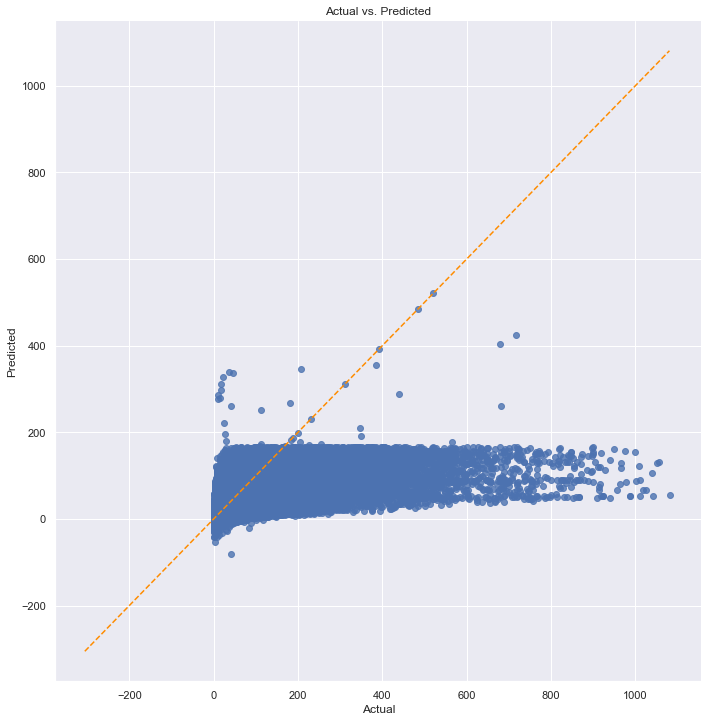

In [26]:
linear_assumption(lin_reg, X, y)

### - Result of Linearity Assumption : Invalid

We can see in this case that there is not a linear relationship at all. Our predictions are biased towards both lower values and higher values. The predicted numbers are all small among low or high actual numbers.

## Assumption 2: Normality of the Error Terms

More specifically, this assumes that the error terms of the model are normally distributed.

### How to detect it: 

There are a variety of ways to do so, but we’ll look at both a histogram and the p-value from the Anderson-Darling test for normality.

### Define a normal errors assumption

In [27]:
def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(20, 12))
    plt.title('Distribution of Residuals')
    sns.distplot(df_results['Residuals'])
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')

### Show the result

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0
Residuals are not normally distributed


/Users/kristylin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/_adnorm.py:70: RuntimeWarning: divide by zero encountered in log1p
  s = np.sum((2 * i[sl1] - 1.0) / nobs * (np.log(z) + np.log1p(-z[sl2])),


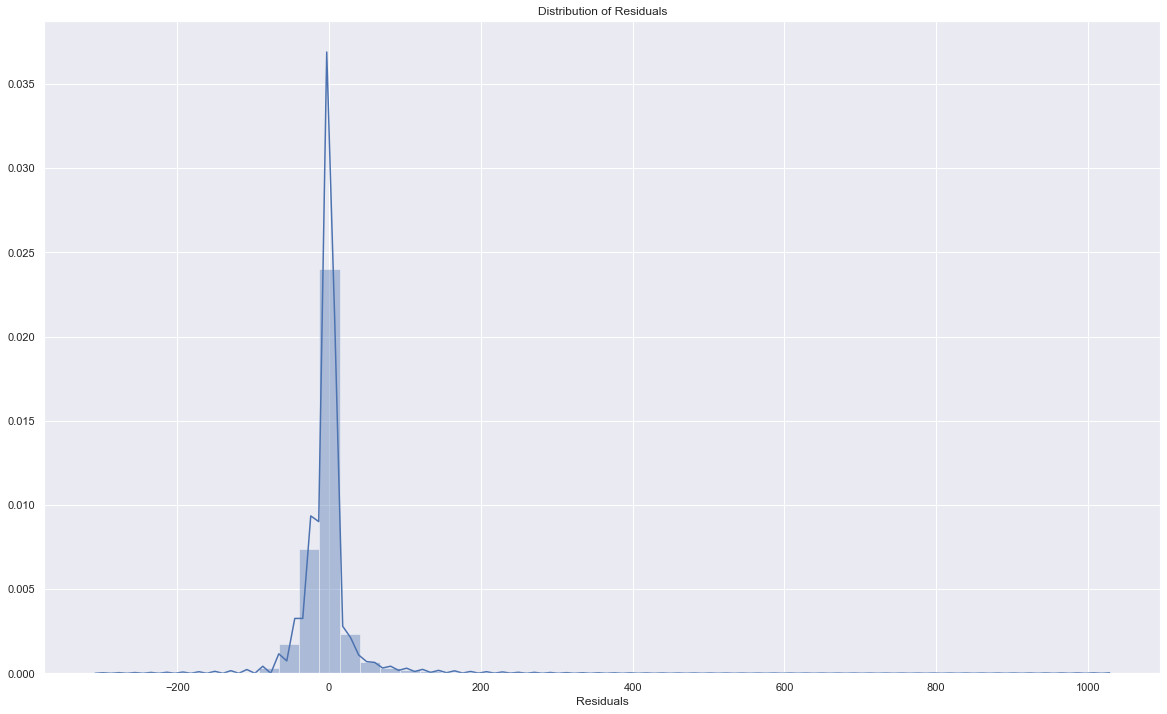


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables


In [28]:
normal_errors_assumption(lin_reg, X, y)

### - Result of Normality of the Error Terms Assumption: Invalid

As we can see from the graph, the error terms are not normally distributed, it's right skewed. This isn’t ideal, and we can see that our model is biasing towards under-estimating.

## Assumption 3: No Autocorrelation of the Error Terms

This assumes no autocorrelation of the error terms. Autocorrelation being present typically indicates that we are missing some information that should be captured by the model.

### How to detect it: 

We will perform a Durbin-Watson test to determine if either positive or negative correlation is present. 

### Define an autocorrelation_assumption function

In [29]:
def autocorrelation_assumption(model, features, label):
    """
    Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                     autocorrelation, then there is a pattern that is not explained due to
                     the current value being dependent on the previous value.
                     This may be resolved by adding a lag variable of either the dependent
                     variable or some of the predictors.
    """
    from statsmodels.stats.stattools import durbin_watson
    print('Assumption 4: No Autocorrelation', '\n')
    
    # Calculating residuals for the Durbin Watson-tests
    df_results = calculate_residuals(model, features, label)

    print('\nPerforming Durbin-Watson Test')
    print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
    print('0 to 2< is positive autocorrelation')
    print('>2 to 4 is negative autocorrelation')
    print('-------------------------------------')
    durbinWatson = durbin_watson(df_results['Residuals'])
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')

### Show the result

In [30]:
autocorrelation_assumption(lin_reg, X, y)

Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 2.0001683936262995
Little to no autocorrelation 

Assumption satisfied


### - Result of No Autocorrelation of the Error Terms Assumption: Valid

From the result, we can find that our data satisfied this assumption. 

## Assumption 4: Homoscedasticity

This assumes homoscedasticity, which is the same variance within error terms. Heteroscedasticity, the violation of homoscedasticity, occurs when we don’t have an even variance across the error terms.

### How to detect it: 

Plot the residuals and see if the variance appears to be uniform.

### Define a homoscedasticity_assumption function

In [31]:
def homoscedasticity_assumption(model, features, label):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show()  

### Plot the residuals

Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


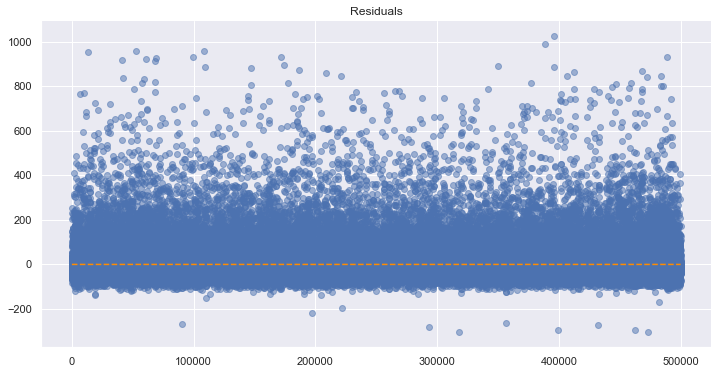

In [32]:
homoscedasticity_assumption(lin_reg, X, y)

### - Result of Homoscedasticity Assumption: Invalid

We can’t see a fully uniform variance across our residuals, so this is potentially problematic.

##  Conclusion of linear regression assumptions

Overall, we can say that the data set does not follow linear regression assumptions. Hence, we can not get the high accuracy on our prediction. Maybe using non-linear approach can have a better performance.

Let's take a look on the performamce of linear regression

# Part4. Performance of Linear Regression Model

### Train the linear regression model

In [33]:
# Train the model
lin_reg.fit(X_train, y_train)
lin_pred_test = lin_reg.predict(X_test)
lin_pred_train = lin_reg.predict(X_train)

# Find the intercept
print('Intercept:', float(lin_reg.intercept_))

# Find the coefficient of variables
print(pd.Series(lin_reg.coef_, index = X.columns)) 

Intercept: -384.14519534865497
INSTALLDATE                -1.583923e-02
LASTACTIVEDAY               1.635190e-02
LEADERMOSTSELECTED          6.492494e-03
CIVILIZATIONMOSTSELECTED    7.236924e-03
POLAND                      9.345081e-07
                                ...     
CIVILIZATION_CG_IONIA      -3.974672e+00
CIVILIZATION_SHIKI          0.000000e+00
CIVILIZATION_ALTMER         0.000000e+00
CIVILIZATION_CW            -1.338621e+01
datediff                    3.219113e-02
Length: 1227, dtype: float64


### Find the R^2 score and MSE of training data and testing data

In [34]:
# Print R^2 of testing data
print('Variance Score (R^2) of testing data:%.2f' % r2_score(y_test, lin_pred_test))
# Print MSE
print("Mean Squared Error (MSE):%.2f" % mean_squared_error(y_test, lin_pred_test))

# Print R^2 of training data
print('Variance Score (R^2) of training data:%.2f' % r2_score(y_train, lin_pred_train))
# Print MSE
print("Mean Squared Error (MSE):%.2f" % mean_squared_error(y_train, lin_pred_train))

Variance Score (R^2) of testing data:0.38
Mean Squared Error (MSE):1554.16
Variance Score (R^2) of training data:0.38
Mean Squared Error (MSE):1498.26


### Result of the performance

- After training the data, we get the same variance score 38% of testing data and training data, the model looks good for the data set.

- The MSE score of the model is 1554 and 1498, which seems good

- However, the R^2 score is too low, which is not good for the prediction.

### Top 15 features importance

In [35]:
# Print the model's coefficient value, and make a ranking dataframe.  
coeff_df = pd.DataFrame(X_train.columns)
coeff_df.columns = ['Features']

coeff_df['Coefficient'] = pd.Series(abs(lin_reg.coef_))
coeff_df_sort = coeff_df.sort_values(by = 'Coefficient', ascending = False).round(4).head(15)
coeff_df_sort

,Features,Coefficient
364,LEADER_JFD_ELISABETH,226.5108
1135,CIVILIZATION_TERRA,216.2645
583,LEADER_YRGOS,216.2645
653,LEADER_sakuya,205.1807
1204,CIVILIZATION_ZOB_CIV_SWEDEN,200.8399
697,LEADER_ZOB_CHARLES_XI,200.8399
381,LEADER_CAF_HITLER,182.2009
600,LEADER_JFD_ATHELSTAN,142.9554
184,LEADER_AR_FREDERICK,107.5809
869,CIVILIZATION_AR_PRUSSIA,107.5809


### Visualizate the result

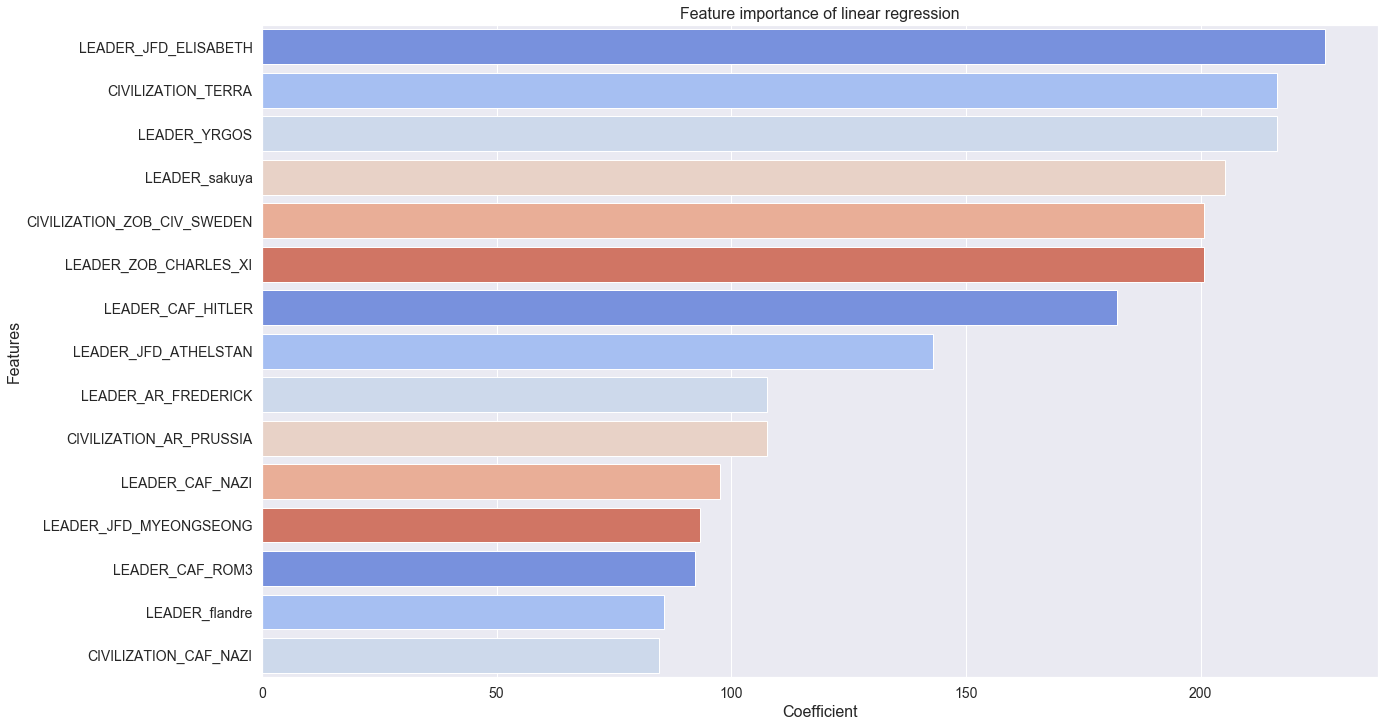

In [36]:
# Set figure size. 
rcParams['figure.figsize'] = (20, 12)

# Make barplot
ax = sns.barplot('Coefficient', 'Features', data = coeff_df_sort.sort_values(by = 'Coefficient', ascending = False), palette = sns.color_palette('coolwarm'), orient = 'h')

# Set x_label, y_label, plot title name.  
ax.set_xlabel('Coefficient', fontsize = 16)
ax.set_ylabel('Features', fontsize = 16)
ax.set_title('Feature importance of linear regression', fontsize = 16)

# Set the fontsize for x axis and y axis. 
ax.tick_params(axis = 'y', labelsize = 14)
ax.tick_params(axis = 'x', labelsize = 14)

### Findings of features importance

From the features importance of linear regression, we can find that:

- The leader that the players selected and the civilization that the players selected have high coefficient with active days.

- Players who selected LEADER_JFD_ELISABETH and CIVILIZATION_TERRA may more active days

From the result, we can conclude that the leader and the civilization that the players selected, can have high influence on the players' active days.

##  Summary of the performance of linear regression

- As we can see from the R^2 score, the score of testing data and training data is the same, which is 38%. The performance of the model is not significant.

- The variables in the data set do have some correlation with active days, but the overall influence is not so significant. 


Below, I will use regularization to check if the model is overfitted and to find if I can get a better R^2 score.

# Part5. Regularization

In this part, I use Ridge to conduct my regularization to see if I can get a better R^2 score. To check if the model is overfitted.

## Ridge

### Split the samples into a training set and a test set

In [37]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

### Fit a ridge model on the training set, using alpha = 0.01

In [38]:
# Fit the model
model = Ridge(alpha = 0.01, normalize = True)
model.fit(X_train, y_train)           
ridge_pred_test = model.predict(X_test)  

print(pd.Series(model.coef_, index = X.columns)) 

INSTALLDATE                -1.587423e-02
LASTACTIVEDAY               1.635868e-02
LEADERMOSTSELECTED          9.805732e-04
CIVILIZATIONMOSTSELECTED   -5.200473e-04
POLAND                      3.299432e-07
                                ...     
CIVILIZATION_CG_IONIA      -5.819022e+00
CIVILIZATION_SHIKI          0.000000e+00
CIVILIZATION_ALTMER         0.000000e+00
CIVILIZATION_CW            -1.496342e+01
datediff                    3.184793e-02
Length: 1227, dtype: float64


### Find the R^2 score and MSE of training data and testing data

In [39]:
# Find the R^2 score on testing data
print('Variance Score (R^2) of testing data: ', r2_score(y_test, ridge_pred_test))
print('MSE of testing data:', mean_squared_error(y_test, ridge_pred_test))

# Find the R^2 score on training data
ridge_pred_train = model.predict(X_train) 
print('Variance Score (R^2) of train data: ', r2_score(y_train, ridge_pred_train))
print('MSE of training data:', mean_squared_error(y_train, ridge_pred_train))

Variance Score (R^2) of testing data:  0.3759842283619824
MSE of testing data: 1554.1542416889718
Variance Score (R^2) of train data:  0.37708428270125627
MSE of training data: 1498.2822849210863


### Result of Regularization

- After regularization, the R^2 score doesen't improve. It's almost the same as that of linear regression.

- The MSE score of testing data is 1554, and training data is 1498.

- Linear regression model is not overfitted. Hence, we can come out the conclusion for the analysis.

# Part6. Conclusion

For the analysis,

(1) First, I selected and created new columns for the features to prepare my data for modeling.There are 1228 columns in my dataframe


(2) Second, I set up my features as dependence variables and independence variables.
    
   - dependence variables (y):
    
        ACTIVEDAYS
        
        
   - independence variables (X): 
    
        INSTALLDATE                 
    
        LASTACTIVEDAY
    
        datediff --> I created new column to calculate the difference between last activity day and install date
    
        LEADERMOSTSELECTED --> I seperated this feature with different values into different columns          
    
        CIVILIZATIONMOSTSELECTED --> I seperated this feature with different values into different columns      
    
        POLAND
    
        BUY_POLAND --> I created this new column to determine whether the players bought the DLCs
    
        NUBIA 
    
        BUY_NUBIA --> I created this new column to determine whether the players bought the DLCs
    
        KHMER_AND_INDONESIA
    
        BUY_KHMER_AND_INDONESIA --> I created this new column to determine whether the players bought the DLCs
    
        GATHERING_STORM
    
        BUY_GATHERING_STORM --> I created this new column to determine whether the players bought expansions
    
        PERSIA_AND_MACEDON 
    
        BUY_PERSIA_AND_MACEDON --> I created this new column to determine whether the players bought the DLCs
    
        VIKINGS
    
        BUY_VIKINGS --> I created this new column to determine whether the players bought the DLCs
    
        RISE_AND_FALL
    
        BUY_RISE_AND_FALL --> I created this new column to determine whether the players bought expansions
    
        AUSTRALIA
    
        BUY_AUSTRALIA --> I created this new column to determine whether the players bought the DLCs
        
        SUM_DLCS --> I created this new column by calculate the sum of DLCs that each players bought
        
        SUM_expansions --> I created this new column by calculate the sum of expansions that each players bought
    
        total --> I created this new column by calculate the sum of expansions/DLCS that each players bought


(3) Third, I set up my linear regression Assumption.

- Assumption 1: Linearity

  The result does not fit linearity
  

- Assumption 2: Normality of the Error Terms

  The result does not fit normality
  

- Assumption 3: No Autocorrelation of the Error Terms

  The result fits the no autocorrelation
  

- Assumption 4: Homoscedasticity

  The result does not fit homoscedastticity
  
From the assumption, we can know that the data does not fit linear regression model. Hence, in this step I assumed that the score of the model would be low.



(4) Finally, I got the result.

- If the model is significant or not. why?
 
  Linear regression model for this data set is not significant. Although I got the same R^2 score on training and testing data, the score of the model is still low, which is only 38%.


- Which of IVs are significant and why?

    LEADER_JFD_ELISABETH and CIVILIZATION_TERRA are the most significant features. It means that the leader/civilization that the players selected will affect their active days.

    Also, the expansions and DLCs that the players have can influence their active days. The more they have, the more of their active days
  
  
- What about coefficients? 

    1. LEADER_JFD_ELISABETH	226.5108
    
    2. CIVILIZATION_TERRA	216.2645
    
    3. LEADER_YRGOS	216.2645
    
    4. LEADER_sakuya	205.1807
    
    5. CIVILIZATION_ZOB_CIV_SWEDEN	200.8399

 The coefficient of these variables are high, which means that they have high correlation with the players' active days


- What is your R square? Is it good or bad?

    Linear regression - 
    
    training set: 0.38
    
    testing set: 0.38
    
    Regularization(Ridge) - 
    
    training set: 0.377
    
    testing set: 0.37

 The score of R square is bad, which means that linear regression approach may not be the best method to conduct the prediction of the data set. Or, the features we have don't have significance relation with active days. Maybe trying nonlinear approach would get a better performance.

# Part7. References

I take the below link as my reference of linear regression assumptions.

[1] Testing Linear Regression Assumptions in Python

https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/